## Plane Wave Model
Merujuk pada tulisan Viljanen 1998, medan listrik arah $y$ yang dibangkitkan oleh gangguan medan magnet saat badai adalah:
$$
    E_y(t) = -\dfrac{1}{\sqrt{\pi\mu_0\sigma}}\int_{-\infty}^{t}\dfrac{g_x(u)}{\sqrt{t-u}}
$$
dengan 
$$
    g_x(u) = \dfrac{dH}{du}
$$
serta beberapa konstant sebagai berikut:
$$
    \pi = 3.1415\newline
    \mu_0 = 1.2566\times10^{-3}\ \text{NA}^{-2}
$$

Misalnya kita gunakan Quebec earth model untuk tebakan awal, maka resistivitas Bumi adalah $\rho=1000\ \Omega\text{m}$ dan konduktivitasnya adalah $\sigma=10^{-3}\ \text{S/m}$.

Nilai koefisien di luar integral bisa kita nyatakan sebagai
$$k=\dfrac{1}{\sqrt{\pi\mu_0\sigma}}=1.5916\times10^{4}\ \text{ms}^{-1/2}$$

Pada prakteknya, kita punya data medan magnet dengan resolusi 1 menit, sehingga perhitungan $E_y$ pada waktu $t$ kita bisa dekati dengan mengintegrasikan $g_x(u)$ selama 10 menit sebelumnya, yakni:

$$
    E_y(t) = -k\left[ \dfrac{g_x(t-30)}{\sqrt{30}} + \dfrac{g_x(t-90)}{\sqrt{90}}+\ldots+
    \dfrac{g_x(t-510)}{\sqrt{570}}\right]
$$
Dengan formulasi di atas, satuan dari bagian dalam kurung siku (bagian integral) adalah nT $\text{s}^{-3/2}$. Setelah dikalikan dengan $k$, satuan dari $E_y$ adalah nT m/s atau setara dengan $10^{-3}$ mV/km.

Perlu dicatat bahwa $g_x(u)$ dinyatakan dalam nT/s dan dihitung di titik tengah interval data magnetometer. Misalnya kita punya $H(t=0\text{ min})=40116$ nT dan $H(t=1\text{ min})=40119$ nT, maka kita bisa hitung 
$$g_x(t=0.5\text{ min})=3\text{ nT/min}=0.05\text{ nT/s}$$

Maka dari itu, nilai $u$ pada fungsi di atas adalah $u=[0.5, 1.5, \ldots, 9.5]\text{ min}$ atau $u=[30, 90, \ldots, 570]\text{ sec}$.
## Tabel konversi

Berikut adalah beberapa hubungan yang perlu diingat dalam melakukan konversi satuan.
| Relasi | Formula |
| --- | --- |
| Watt, Newton | $W=N m/s$ |
| Watt, Volt, Ampere | $W = VA$ |
| Volt, Ampere, Ohm | $V=A\Omega$ |
| Tesla, Volt | $T=Vs/m^2$ |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt

C:\Apps\Anaconda3\envs\local\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def el_field(g, window=30, rho=1000):
    k = np.sqrt(rho/3.9477e-6)*1e-3 #supaya luaran E_y dalam mV/km
    y = [np.nan]*window
    for i in range(window, len(g)):
        v = 0
        for j in range(1,window):
            v += g[i-j]/np.sqrt(j*60+30)
        y.append(v)
    return k*np.array(y)

def calc_integral(g, window=10):
    y = [np.nan]*window
    for i in range(window, len(g)):
        v = 0
        for j in range(1,window):
            v += g[i-j]/np.sqrt(j*60+30)
        y.append(v)
    return np.array(y)

In [6]:
raw = pd.read_csv('../data/Mother-KPG.csv')

minute = np.repeat(np.arange(60).reshape((1,60)), 96, axis=0).flatten()
raw['minute'] = minute
timestamp = [pd.Timestamp(year=int(a.year), month=int(a.month), 
                          day=int(a.day), hour=int(a.hour), minute=int(a.minute)) 
             for b,a in raw.iterrows()]
timestamp = np.array(timestamp)
raw['timestamp'] = timestamp

raw = raw.dropna()

In [7]:
dt = np.array([a.seconds for a in (timestamp[1:] - timestamp[:-1])])
dhdt = (raw.H_mean.values[1:] - raw.H_mean.values[:-1])/dt
dddt = (raw.D_mean.values[1:] - raw.D_mean.values[:-1])/dt
#inty = calc_integral(dhdt)
el_x = el_field(dddt, window=30, rho=5000)
el_y = -el_field(dhdt, window=30, rho=5000)

print('max(Ex)', np.nanmax(el_x))
print('max(Ey)', np.nanmax(el_y))

data = raw.copy()
data['dhdt'] = np.append([np.nan], dhdt)
data['dddt'] = np.append([np.nan], dddt)
data['el_x'] = np.append([np.nan], el_x)
data['el_y'] = np.append([np.nan], el_y)

max(Ex) 12.771063192118206
max(Ey) 4.707451943049803


In [ ]:
data.to_csv('../data/GIC-240510-KPG.csv', index=False)

In [ ]:
for a in np.random.randint(1000, high=2000, size=10):
    z = dhdt[a:a+100]
    y = []
    x = np.arange(10,65,1)
    for i in x:
        a = el_field(z, window=i)
        y.append(np.mean(a[70:]))

    plt.plot(x, y, '-k')
plt.show()

In [ ]:
data = pd.read_csv('../data/GIC-240510-PTN.csv')

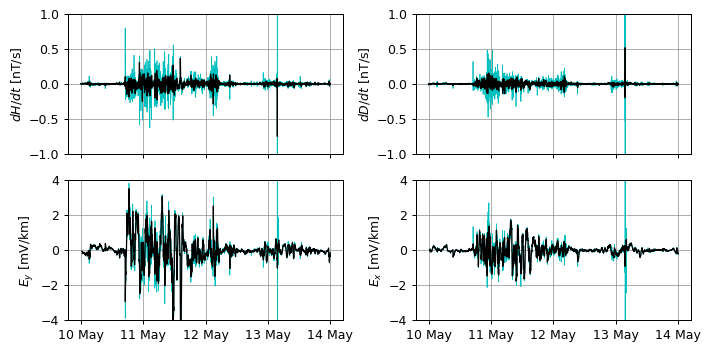

In [8]:
fig,ax = plt.subplots(2, 2, figsize=(8,4), dpi=90, sharex=True)
ax = ax.flatten()
param = {'dhdt':(r'$dH/dt$ [nT/s]', 1), 
         'dddt':(r'$dD/dt$ [nT/s]', 1), 
         'el_y':(r'$E_y$ [mV/km]', 4), 
         'el_x':(r'$E_x$ [mV/km]', 4)}

for i,p in enumerate(param.keys()):
    md = medfilt(data[p].values, kernel_size=5)
    ax[i].plot(data['timestamp'], data[p], '-c', lw=0.6)
    ax[i].plot(data['timestamp'], md, '-k', lw=1)
    ax[i].set_ylabel(param[p][0])
    ax[i].set_ylim(-param[p][1], param[p][1])
    ax[i].grid(color='gray', lw=0.5)
days = [10,11,12,13,14]
labl = [f'{a} May' for a in days]
ts = [pd.Timestamp(year=2024,month=5,day=a) for a in days]
ax[-1].set_xticks(ts)
ax[-1].set_xticklabels(labl)

plt.tight_layout()
plt.savefig('fig/GIC-240510-KPG.png')
plt.savefig('fig/GIC-240510-KPG.pdf')
plt.show()

Misalkan amplitude maksimum $E_x$ dan $E_y$ adalah 1 mV/km. Berapa kira-kira GIC yang dibangkitkan?

Anggap nilai $a=100$
$$I=\dfrac{1}{R}\int Edl$$

In [ ]:
data.dtypes